# Introduction

This notebook uses scikit-learn and several machine learning models to predict if a patient is likely to get a stroke. Being able to determine which patients have high stroke risk will allow doctors to advise them and their families on how to act in case of an emergency. The dataset is [Stroke Prediction Dataset](https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset/data) from Kaggle.

# Pre-Modeling

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as stats
import xgboost as xgb
import statsmodels.stats.proportion as smp
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix, classification_report, f1_score, precision_recall_curve
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from scipy.stats import norm, randint, uniform
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

In [2]:
path = "healthcare-dataset-stroke-data.csv"
stroke_df = pd.read_csv(path, usecols=lambda col: col != 'Unnamed: 0')

## EDA

### At A Glance

In [3]:
stroke_df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [4]:
stroke_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


There are 9 features plus the target variable (stroke) and an id column.

The "bmi" column has 201 NaNs. I will handle them later with my preprocessor.

In [5]:
duplicate_ids = stroke_df["id"][stroke_df["id"].duplicated(keep=False)].unique()
print(duplicate_ids)

[]


There are no duplicates in the "id" column, which I understand to be labeling unique patients. 

In [6]:
stroke_df.shape

(5110, 12)

In [7]:
label = f"Unique Responses in Categorical Features:"
print(label)
print(stroke_df['gender'].unique())
print(stroke_df['hypertension'].unique())
print(stroke_df['heart_disease'].unique())
print(stroke_df['ever_married'].unique())
print(stroke_df['work_type'].unique())
print(stroke_df['Residence_type'].unique())
print(stroke_df['smoking_status'].unique())
print(stroke_df['stroke'].unique())

Unique Responses in Categorical Features:
['Male' 'Female' 'Other']
[0 1]
[1 0]
['Yes' 'No']
['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']
['Urban' 'Rural']
['formerly smoked' 'never smoked' 'smokes' 'Unknown']
[1 0]


### Outlier Investigation

In [8]:
stroke_df.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


Some notable data stand out as being worth further investigation. The minimum for age is 0.08 and for bmi 10.3. The maximum for bmi is 97.6.

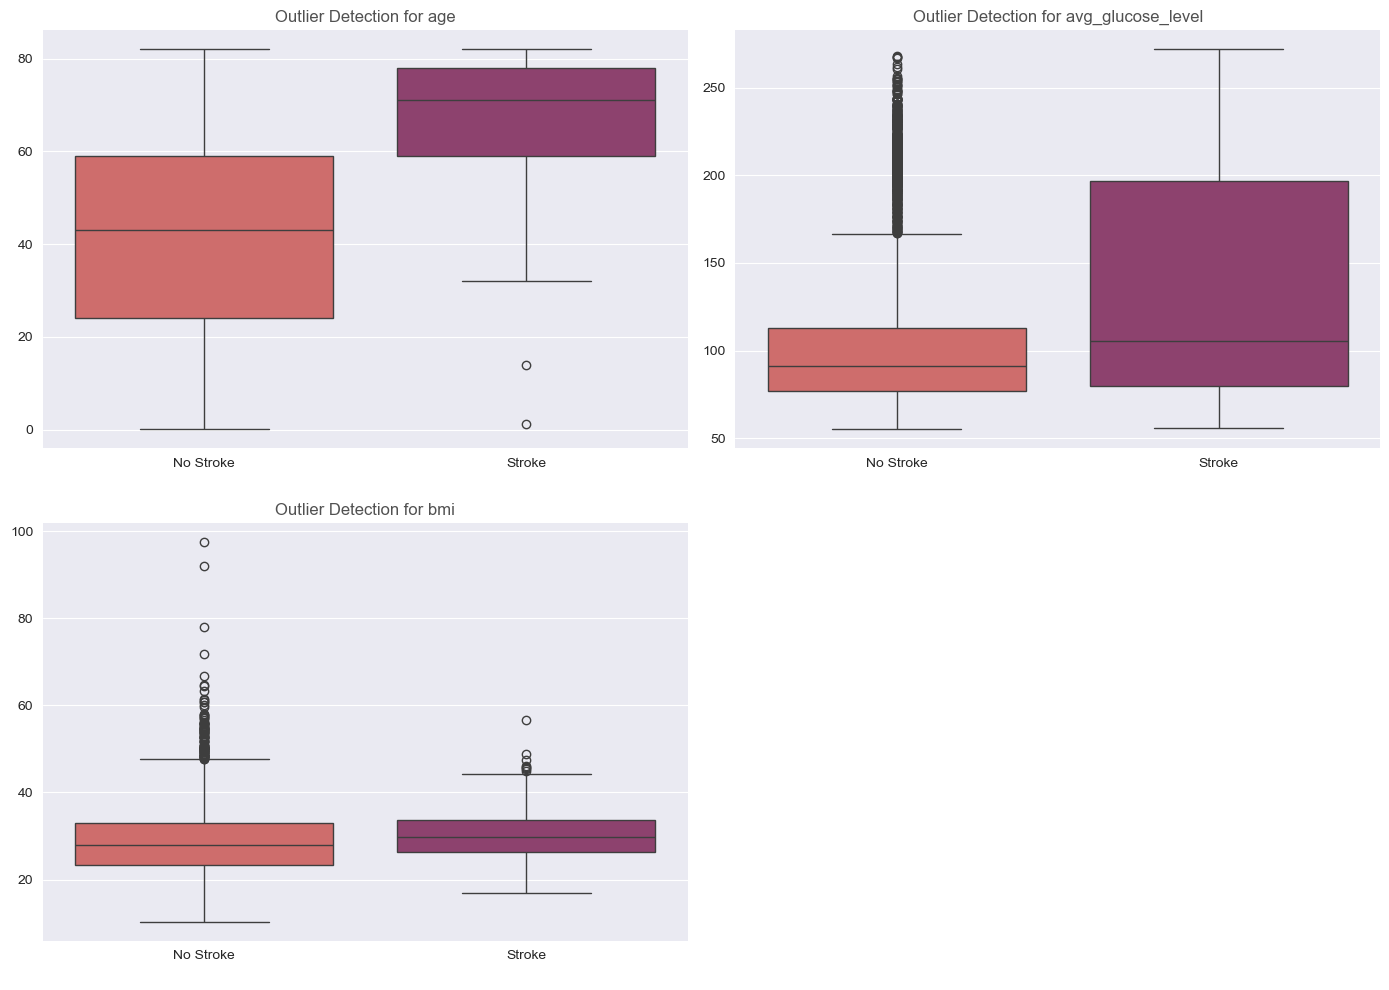

In [9]:
sns.set_style("darkgrid")

numerical_features = ["age", "avg_glucose_level", "bmi"]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
axes = axes.flatten()

for i, feature in enumerate(numerical_features):
    
    sns.boxplot(x='stroke', hue='stroke', legend=False, y=feature, data=stroke_df, ax=axes[i], palette='flare')
    
    sns.despine(left=True, bottom=True, right=True, top=True)
    axes[i].set_xlabel(' ')
    axes[i].set_ylabel("")
    axes[i].set_title(f'Outlier Detection for {feature}', fontsize=12, alpha=0.8)
    axes[i].tick_params(axis='x', which='both', left=False, bottom=False)
    
    axes[i].set_xticks([0, 1])
    axes[i].set_xticklabels(['No Stroke', 'Stroke'])

for j in range(len(numerical_features), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

+ No Stroke outliers: avg_glucose_level (upper), bmi (upper)
+ Stroke outliers: age (lower), bmi (upper)

In [10]:
babies = stroke_df[(stroke_df["age"] < 1)]
babies = babies.sort_values(by="age", ascending=True)
babies

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
1614,47350,Female,0.08,0,0,No,children,Urban,139.67,14.1,Unknown,0
3295,29955,Male,0.08,0,0,No,children,Rural,70.33,16.9,Unknown,0
3968,41500,Male,0.16,0,0,No,children,Rural,69.79,13.0,Unknown,0
3618,22877,Male,0.16,0,0,No,children,Urban,114.71,17.4,Unknown,0
4021,8247,Male,0.16,0,0,No,children,Urban,109.52,13.9,Unknown,0
4293,69222,Male,0.24,0,0,No,children,Urban,57.09,19.4,Unknown,0
996,53279,Male,0.24,0,0,No,children,Rural,118.87,16.3,Unknown,0
1999,42500,Male,0.24,0,0,No,children,Rural,146.97,18.5,Unknown,0
2898,64974,Male,0.24,0,0,No,children,Urban,58.35,18.6,Unknown,0
3392,11371,Male,0.24,0,0,No,children,Urban,89.28,14.2,Unknown,0


In [11]:
under_20_stroke = stroke_df[(stroke_df["age"] < 20) & (stroke_df["stroke"] == 1)]
under_20_stroke

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
162,69768,Female,1.32,0,0,No,children,Urban,70.37,NaN,Unknown,1
245,49669,Female,14.00,0,0,No,children,Rural,57.93,30.9,Unknown,1


A 1-year old and a 14-year old are the 2 lower outliers in "age" for those who have had strokes. 

#### bmi

In [12]:
bmi_outlier_stroke = stroke_df[(stroke_df["bmi"] > 43) & (stroke_df["stroke"] == 1)]
bmi_outlier_stroke = bmi_outlier_stroke.sort_values(by="bmi", ascending=False)
bmi_outlier_stroke

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
113,41069,Female,45.0,0,0,Yes,Private,Rural,224.10,56.6,never smoked,1
21,13861,Female,52.0,1,0,Yes,Self-employed,Urban,233.29,48.9,never smoked,1
66,17004,Female,70.0,0,0,Yes,Private,Urban,221.58,47.5,never smoked,1
190,24905,Female,65.0,0,0,Yes,Private,Urban,205.77,46.0,formerly smoked,1
79,42117,Male,43.0,0,0,Yes,Self-employed,Urban,143.43,45.9,Unknown,1
163,20426,Female,78.0,1,0,No,Private,Urban,203.87,45.7,never smoked,1
196,58267,Male,70.0,1,0,Yes,Private,Rural,242.52,45.5,formerly smoked,1
176,62466,Female,80.0,0,0,Yes,Private,Urban,64.44,45.0,never smoked,1
30,43717,Male,57.0,1,0,Yes,Private,Urban,212.08,44.2,smokes,1
80,57419,Male,59.0,0,0,Yes,Private,Rural,96.16,44.1,Unknown,1


In [13]:
bmi_outlier_no_stroke = stroke_df[(stroke_df["bmi"] > 65) & (stroke_df["stroke"] == 0)]
bmi_outlier_no_stroke = bmi_outlier_no_stroke.sort_values(by="bmi", ascending=False)
bmi_outlier_no_stroke

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
2128,56420,Male,17.0,1,0,No,Private,Rural,61.67,97.6,Unknown,0
4209,51856,Male,38.0,1,0,Yes,Private,Rural,56.90,92.0,never smoked,0
928,41097,Female,23.0,1,0,No,Private,Urban,70.03,78.0,smokes,0
544,545,Male,42.0,0,0,Yes,Private,Rural,210.48,71.9,never smoked,0
1559,37759,Female,53.0,0,0,Yes,Private,Rural,72.63,66.8,Unknown,0


A 17 year old male seems unlikely to have a bmi of 97.6. At 6 feet tall, he would have to weigh 714 pounds. While in the realm of possibility, it does not seem likely. Similarly, the 38 year old male with the bmi of 92 would have to weigh 680 pounds at six feet tall -- technically possible, but it seems safe to assume these extreme bmi values in the 90s are data entry errors. The next descending case is a big jump down to bmi 78, indicating this individual probably weighed around 500 lbs. While this is an unusually high weight, it doesn't strike as impossible.

### Proportions in the Data

#### Stroke/No Stroke (Target Variable)

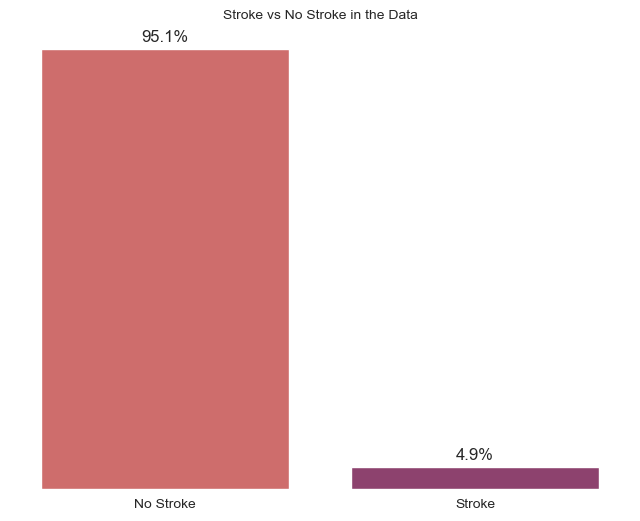

In [14]:
sns.set_style("white")

plt.figure(figsize=(8, 6))
ax = sns.countplot(x='stroke', hue='stroke', legend=False, data=stroke_df, palette='flare')

# Calculate percentages
total_count = len(stroke_df)
for container in ax.containers:
    for bar in container:
        height = bar.get_height()
        percentage = (height / total_count) * 100
        ax.bar_label(container, labels=[f'{percentage:.1f}%' for bar in container], label_type='edge', fontsize=12, padding=3)

plt.title('Stroke vs No Stroke in the Data', fontsize=10)
plt.xlabel('')
plt.ylabel('')
plt.gca().tick_params(axis='y', which='both', left=False, labelleft=False)
plt.gca().tick_params(axis='x', which='both', left=False, bottom=False)
plt.xticks(ticks=[0, 1], labels=['No Stroke', 'Stroke'], rotation=0)
sns.despine(left=True, bottom=True, right=True, top=True)
plt.show()

The dataset is highly imbalanced on the target variable, with less than 5% of respondents reporting having a stroke. This will have to be accounted for in later modeling.

#### Gender

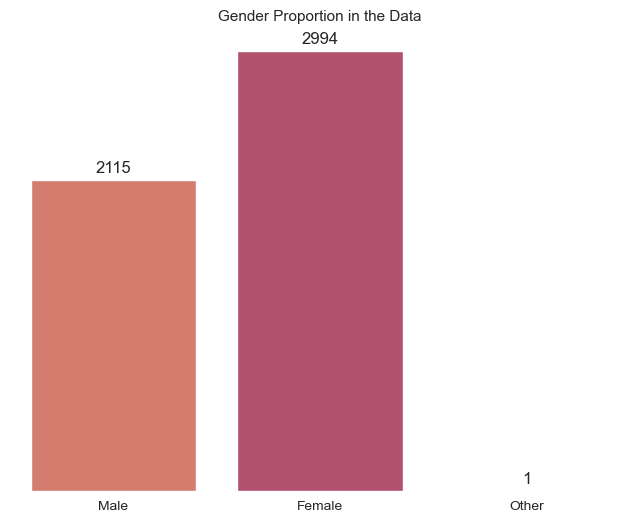

In [15]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='gender', hue='gender', legend=False, data=stroke_df, palette='flare')

for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', fontsize=12, padding=3)

plt.title('Gender Proportion in the Data', fontsize=11)

plt.gca().tick_params(axis='y', which='both', left=False, labelleft=False)
plt.gca().tick_params(axis='x', which='both', left=False, bottom=False)

sns.despine(left=True, bottom=True, right=True, top=True)
plt.xlabel('', fontsize=12)
plt.ylabel('', fontsize=12)
plt.show()

~41.39% of the respondents reported male, ~58.59 reported female, and only 1 respondent reported other (~0.02%).

In [16]:
stroke_df[stroke_df['gender'] == 'Other']

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
3116,56156,Other,26.0,0,0,No,Private,Rural,143.33,22.4,formerly smoked,0


This person did not have a stroke.

### Correlations

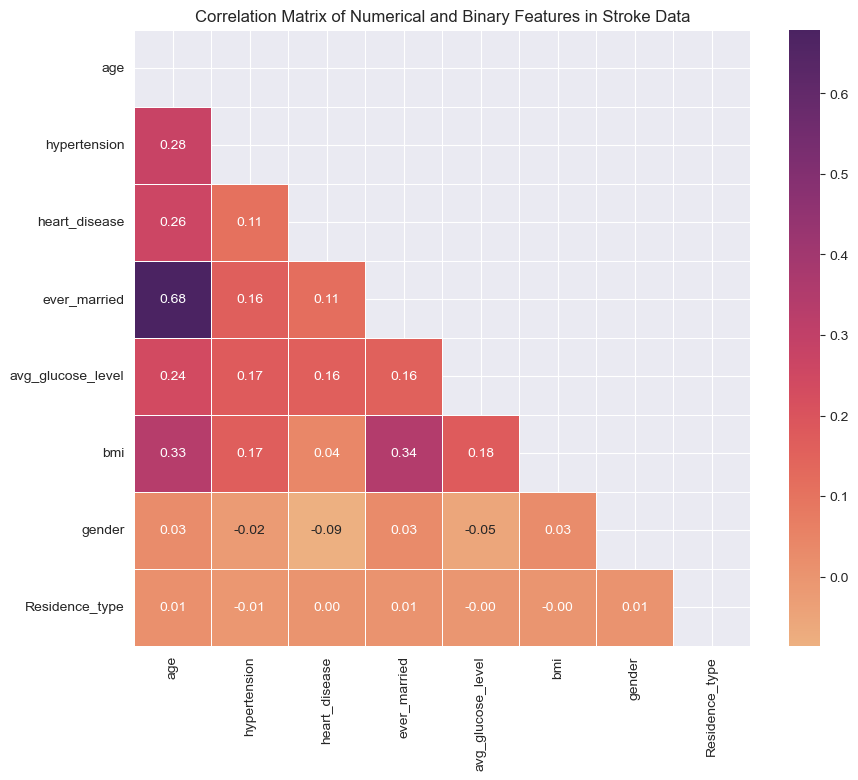

In [17]:
sns.set_style("darkgrid")
stroke_df_corr = stroke_df.copy()
stroke_df_corr['gender'] = stroke_df['gender'].map({'Female': 1, 'Male': 0})
stroke_df_corr['ever_married'] = stroke_df['ever_married'].map({'Yes': 1, 'No': 0})
stroke_df_corr['Residence_type'] = stroke_df['Residence_type'].map({'Urban': 1, 'Rural': 0})

corr_features = ['age', 'hypertension', 'heart_disease', 
                 'ever_married', 'avg_glucose_level', 'bmi', 'gender', 'Residence_type']

correlation_matrix = stroke_df_corr[corr_features].corr()

mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))


plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='flare', 
            fmt='.2f', linewidths=0.5, square=True, cbar=True)

plt.title("Correlation Matrix of Numerical and Binary Features in Stroke Data", fontsize=12)
plt.show()

One moderately strong positive correlation is present: age and ever_married, at 0.68.

## Visualizing Feature Relationships

### Categories Within Features

In [18]:
bins = [0, 10, 22, 45, 65, float('inf')] 
labels = ['Child', 'Adolescent', '22-45', '46-65', 'Over 65']
stroke_df['age_category'] = pd.cut(stroke_df['age'], bins=bins, labels=labels, right=True)

bins = [0, 18.5, 25, 30, 35, 40, float('inf')]
labels = ['Underweight', 'Normal Weight', 'Overweight', 'Class 1 Obesity', 'Class 2 Obesity', 'Class 3 Obesity']
stroke_df['bmi_category'] = pd.cut(stroke_df['bmi'], bins=bins, labels=labels, right=True)

bins = [50, 72, 120, 215, float('inf')]
labels = ['Low', 'Normal', 'Borderline', 'High']
stroke_df['avg_glucose_category'] = pd.cut(stroke_df['avg_glucose_level'], bins=bins, labels=labels, right=True)

### Visuals

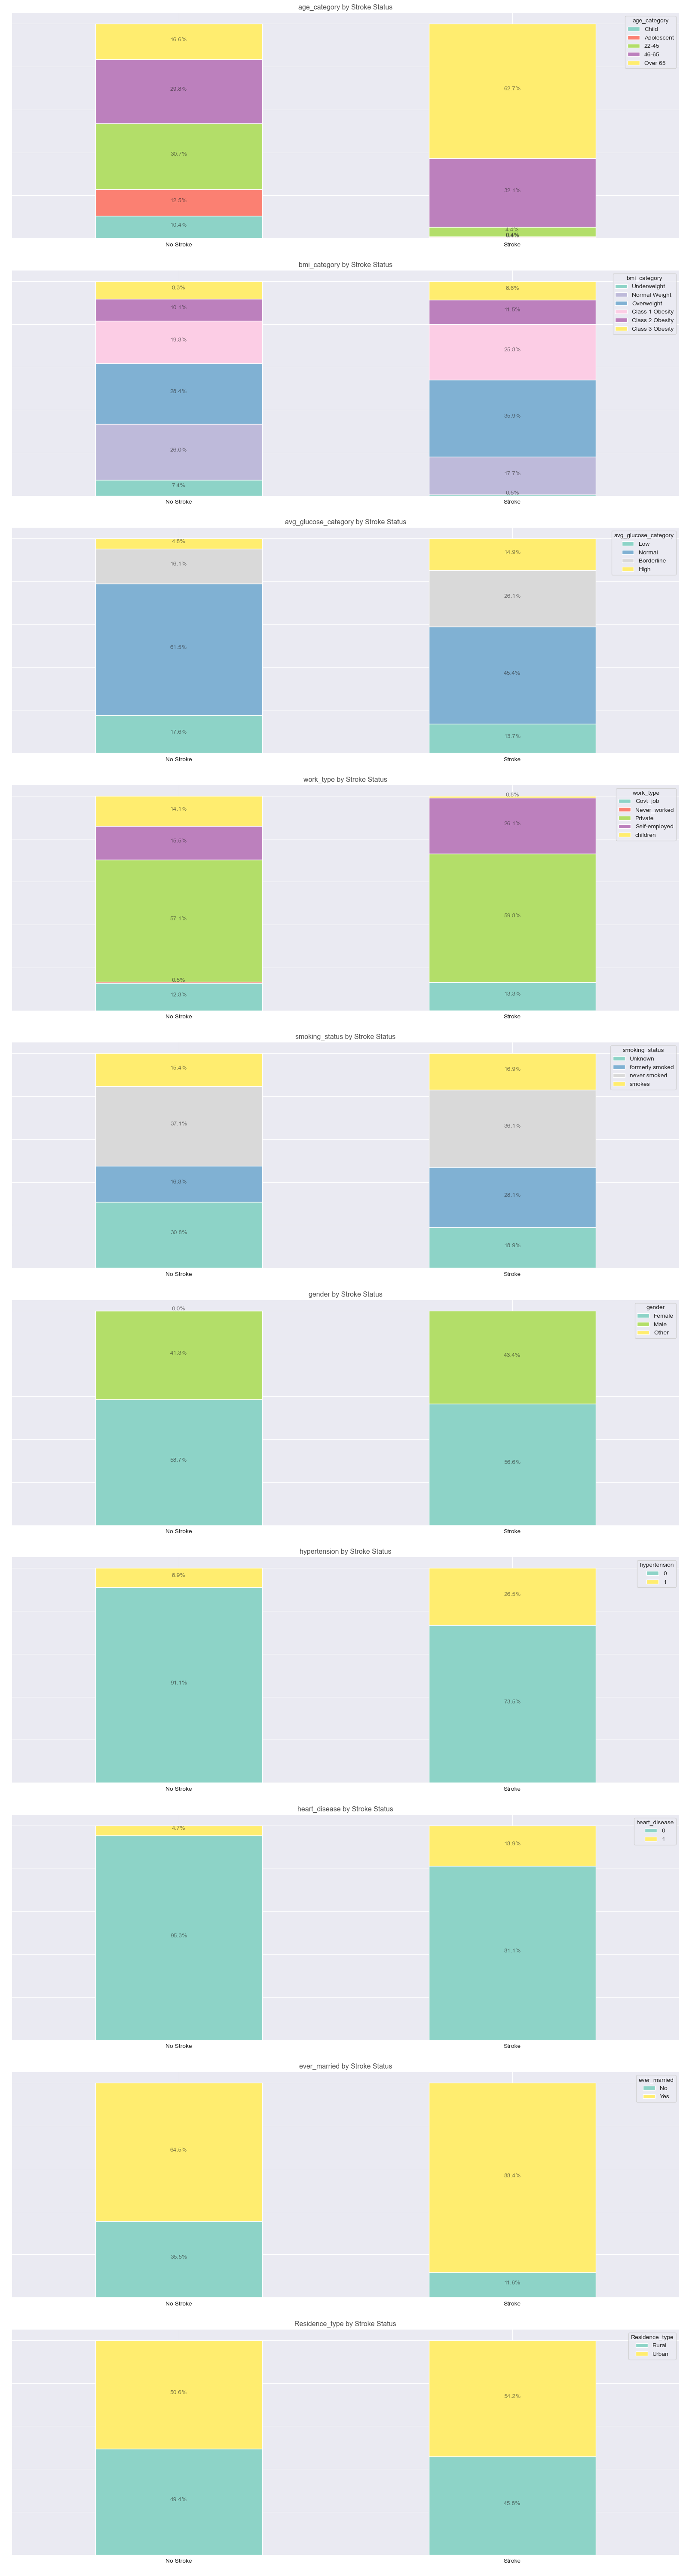

In [19]:
sns.set_style("darkgrid")

categorical_features = ['age_category', 'bmi_category', 'avg_glucose_category', 'work_type', 'smoking_status']
binary_features = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'Residence_type']

all_features = categorical_features + binary_features

fig, axes = plt.subplots(nrows=len(all_features), ncols=1, figsize=(16, 60))
axes = axes.flatten()

for i, feature in enumerate(all_features):
    pivot_df = stroke_df.pivot_table(index='stroke', columns=feature, aggfunc='size', fill_value=0, observed=False)
    pivot_df_percentage = pivot_df.div(pivot_df.sum(axis=1), axis=0) * 100

    ax = pivot_df_percentage.plot(kind='bar', stacked=True, ax=axes[i], colormap='Set3')

    for c in ax.containers:
        labels = [f'{v:.1f}%' if v > 0 else '' for v in c.datavalues]
        ax.bar_label(c, labels=labels, label_type='center', padding=3, alpha=0.6)

    sns.despine(left=True, bottom=True, right=True, top=True)
    ax.tick_params(axis='y', which='both', left=False, labelleft=False)
    ax.tick_params(axis='x', which='both', left=False, bottom=False)
    ax.set_xlabel(' ')
    ax.set_ylabel(' ')
    ax.set_title(f'{feature} by Stroke Status', fontsize=11.5, alpha=0.8)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['No Stroke', 'Stroke'], rotation=0)


plt.tight_layout()
plt.show()


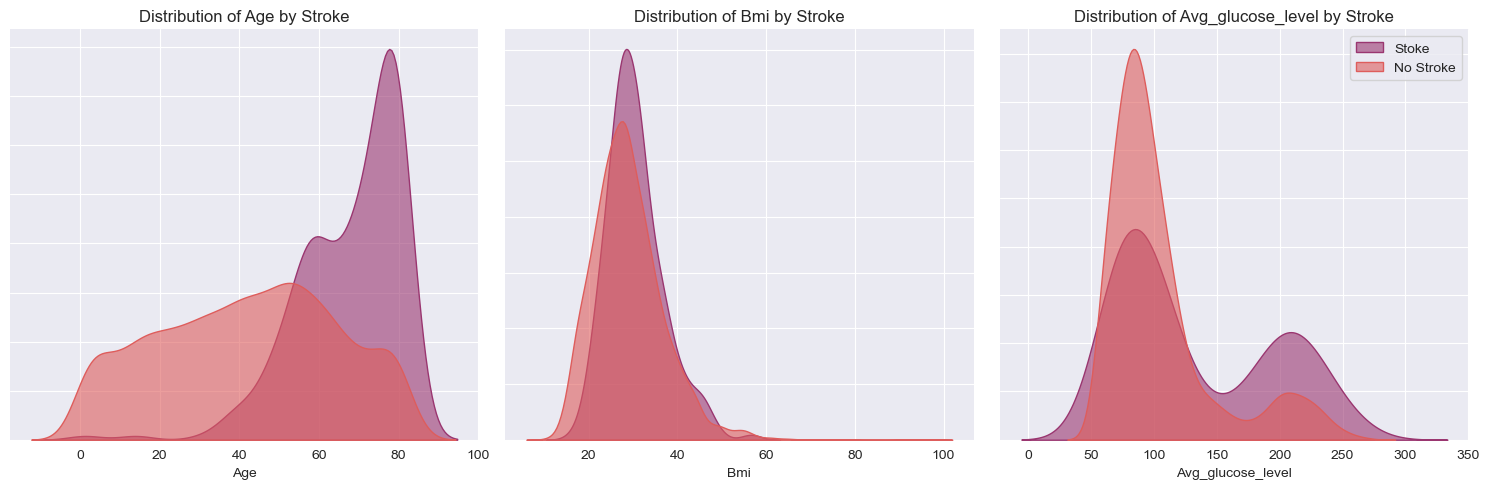

In [20]:
features = ['age', 'bmi', 'avg_glucose_level']

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, feature in enumerate(features):
    ax = axes[i]
    sns.kdeplot(data=stroke_df, x=feature, hue='stroke', fill=True, common_norm=False, 
                palette='flare', alpha=0.6, ax=ax, legend=False)
    
    ax.set_title(f'Distribution of {feature.capitalize()} by Stroke')
    ax.set_xlabel(feature.capitalize())
    ax.set_yticklabels('')
    ax.set_ylabel('')

plt.legend(title='', loc='upper right', labels=['Stoke', 'No Stroke'])
sns.despine(top=True, right=True, left=True, bottom=True)

plt.tight_layout()
plt.show()

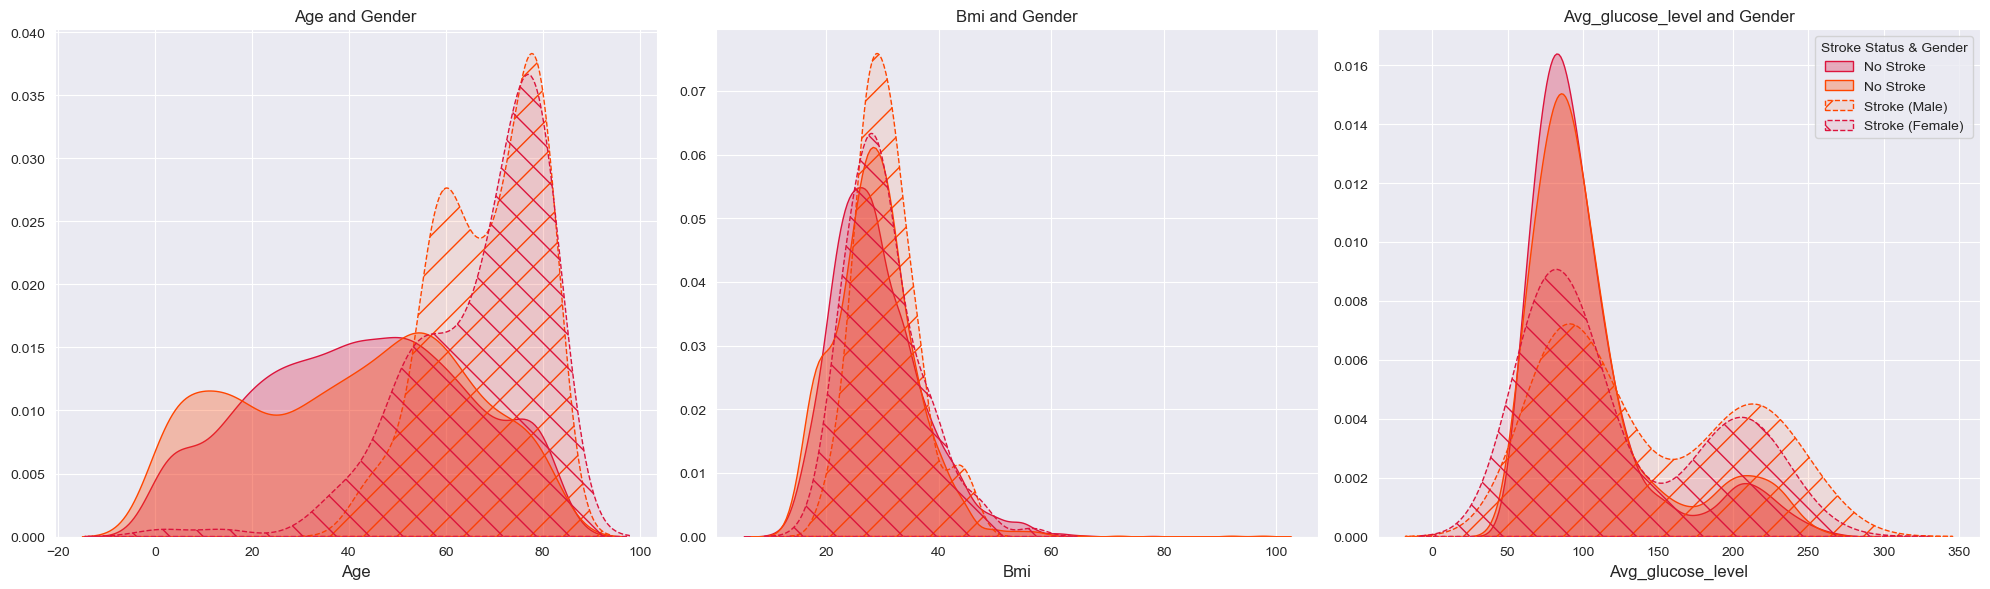

In [21]:

palette = {'Male': 'orangered', 'Other': 'yellow', 'Female': 'crimson'}
hatch_patterns = {'Male': '/', 'Female': '\\'}

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for idx, feature in enumerate(['age', 'bmi', 'avg_glucose_level']):
    ax = axes[idx]
    
    sns.kdeplot(data=stroke_df[stroke_df['stroke'] == 0], x=feature, hue='gender', fill=True, common_norm=False, 
                palette=palette, linewidth=1, warn_singular=False, linestyle='-', label=f'No Stroke', alpha=0.3, ax=ax)
    
    
    for gender in ['Male', 'Female']:
        subset = stroke_df[(stroke_df['stroke'] == 1) & (stroke_df['gender'] == gender)]
        if not subset.empty: 
            sns.kdeplot(data=subset, x=feature, hue='gender', fill=True, common_norm=False, 
                        palette={gender: palette[gender]}, linewidth=1, linestyle='--', alpha=0.1, label=f'Stroke ({gender})', 
                        hatch=hatch_patterns[gender], ax=ax)


    ax.set_title(f'{feature.capitalize()} and Gender', fontsize=12)
    ax.set_xlabel(feature.capitalize(), fontsize=12)
    ax.set_ylabel('', fontsize=12)
    
    
    if idx == 2:  
        ax.legend(title='Stroke Status & Gender', loc='upper right')
    else:
        ax.legend().set_visible(False)

plt.tight_layout()
plt.show()

It seems from these plots that men and women have different trends relating to strokes, particularly notable in the age category. Men experience a spike in strokes around age 60, whereas females almost level off at this time before risk begins to rise again around age 63 joins the highest peak in an identical way to males a bit before age 80.

## Hypothesis Testing

### Hypothesis Set 1

+ Null Hypothesis 1 (H₀): The proportion of males who have had strokes is equal to the proportion of females who have had strokes.
+ Alternate Hypothesis 1 (H₁): The proportion of males who have had strokes is not equal to the proportion of females who have had strokes.

#### Assumptions

For hypothesis testing involving proportions, the focus is on the sampling distribution of the proportions.

In [22]:
stroke_male = np.sum((stroke_df['stroke'] == 1) & (stroke_df['gender'] == "Male")) 
stroke_female = np.sum((stroke_df['stroke'] == 1) & (stroke_df['gender'] == "Female"))
n_male = np.sum(stroke_df["gender"] == "Male")
n_female = np.sum(stroke_df["gender"] == "Female")

print("Males with strokes: ", stroke_male)
print("Females with strokes: ", stroke_female)
print("Total males: ", n_male)
print("Total females: ", n_female)

Males with strokes:  108
Females with strokes:  141
Total males:  2115
Total females:  2994


There is enough data in each class to proceed with a 2-tailed Z-test.

#### 2-Tailed Z-Test

In [23]:
p_male = stroke_male / n_male
p_female = stroke_female / n_female

se = (p_male * (1 - p_male) / n_male + p_female * (1 - p_female) / n_female) ** 0.5

z = (p_male - p_female) / se

p_value = 2 * (1 - stats.norm.cdf(abs(z))) 

print(f'Z-Statistic: {z}')
print(f'P-Value: {p_value}')


if p_value < 0.05:
    print("Reject the null hypothesis: The proportion of males and females who have had strokes is significantly different.")
else:
    print("Fail to reject the null hypothesis: The proportion of males and females who have had strokes is not significantly different.")


Z-Statistic: 0.6448137767172617
P-Value: 0.5190478729727204
Fail to reject the null hypothesis: The proportion of males and females who have had strokes is not significantly different.


#### Confidence Intervals

In [24]:
diff = p_male - p_female
se = np.sqrt((p_male * (1 - p_male)) / n_male + (p_female * (1 - p_female)) / n_female)

z_critical = norm.ppf(0.975)  

margin_error = z_critical * se

ci_lower = diff - margin_error
ci_upper = diff + margin_error

print(f"Difference in proportions (male - female): {diff:.4f}")
print(f"95% Confidence Interval: ({ci_lower:.4f}, {ci_upper:.4f})")

Difference in proportions (male - female): 0.0040
95% Confidence Interval: (-0.0081, 0.0160)


The confidence interval includes 0, supporting the Z-Test's conclusion that there is no statistically significant difference in incidence of strokes between males and females.

### Hypothesis Set 2

+ Null Hypothesis 1 (H₀): The mean age of stroke patients is the same than that of non-stroke patients.
+ Alternate Hypothesis 1 (H₁): The mean age of stroke patients is significantly different than that of non-stroke patients.

#### Assumptions

Shapiro-Wilk test for stroke patients: p-value = 3.173724865197424e-13
The distribution of age for stroke patients does not appear to be normally distributed (reject H₀).
Shapiro-Wilk test for non-stroke patients: p-value = 1.6332581961459548e-30
The distribution of age for non-stroke patients does not appear to be normally distributed (reject H₀).


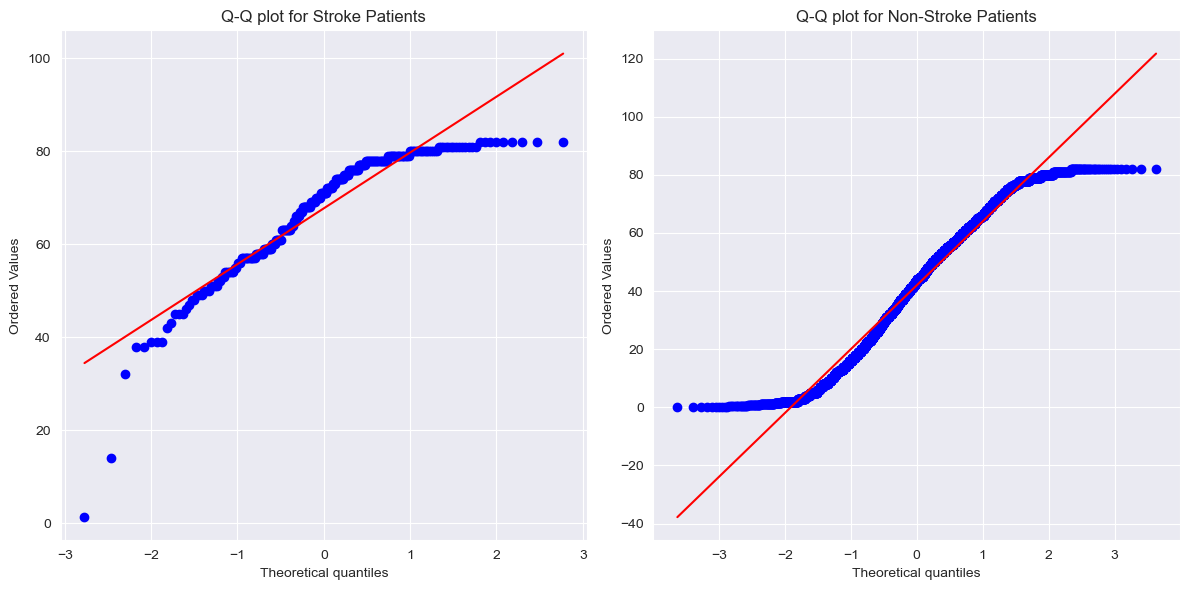

In [25]:
age_stroke = stroke_df[stroke_df['stroke'] == 1]['age']
age_no_stroke = stroke_df[stroke_df['stroke'] == 0]['age']


stat_stroke, p_value_stroke = stats.shapiro(age_stroke)
stat_no_stroke, p_value_no_stroke = stats.shapiro(age_no_stroke)


print(f"Shapiro-Wilk test for stroke patients: p-value = {p_value_stroke}")
if p_value_stroke > 0.05:
    print("The distribution of age for stroke patients appears to be normally distributed (fail to reject H₀).")
else:
    print("The distribution of age for stroke patients does not appear to be normally distributed (reject H₀).")

print(f"Shapiro-Wilk test for non-stroke patients: p-value = {p_value_no_stroke}")
if p_value_no_stroke > 0.05:
    print("The distribution of age for non-stroke patients appears to be normally distributed (fail to reject H₀).")
else:
    print("The distribution of age for non-stroke patients does not appear to be normally distributed (reject H₀).")


plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
stats.probplot(age_stroke, dist="norm", plot=plt)
plt.title("Q-Q plot for Stroke Patients")

plt.subplot(1, 2, 2)
stats.probplot(age_no_stroke, dist="norm", plot=plt)
plt.title("Q-Q plot for Non-Stroke Patients")

plt.tight_layout()
plt.show()


The data is not normally distributed. I will therefore use the Mann-Whitney U Test, which is robust to non-normal data.

#### Mann-Whitney U Test

In [26]:
stat, p_value = stats.mannwhitneyu(age_stroke, age_no_stroke, alternative='two-sided')

print(f"Mann-Whitney U test statistic: {stat}")
print(f"P-value: {p_value}")

if p_value < 0.05:
    print("The difference between the age distributions of stroke and non-stroke patients is statistically significant (reject H₀).")
else:
    print("There is no significant difference between the age distributions of stroke and non-stroke patients (fail to reject H₀).")


Mann-Whitney U test statistic: 1010125.5
P-value: 3.726634665900011e-71
The difference between the age distributions of stroke and non-stroke patients is statistically significant (reject H₀).


#### Confidence Intervals (Bootstrapped to Account for Non-normality)

In [27]:

n_iterations = 10000
np.random.seed(42)

def median_difference(stroke_data, no_stroke_data):
    return np.median(stroke_data) - np.median(no_stroke_data)

bootstrap_differences = []

for _ in range(n_iterations):
    stroke_sample = np.random.choice(age_stroke, size=len(age_stroke), replace=True)
    no_stroke_sample = np.random.choice(age_no_stroke, size=len(age_no_stroke), replace=True)
    
    bootstrap_differences.append(median_difference(stroke_sample, no_stroke_sample))


ci_lower = np.percentile(bootstrap_differences, 2.5)
ci_upper = np.percentile(bootstrap_differences, 97.5)

print(f"Bootstrapped 95% Confidence Interval for the difference in medians:")
print(f"Lower Bound: {ci_lower}")
print(f"Upper Bound: {ci_upper}")

if ci_lower <= 0 <= ci_upper:
    print("The confidence interval includes zero, so there is no statistically significant difference in median  age of those who have strokes.")
else:
    print("The confidence interval does not include zero, indicating a statistically significant difference in median age of those who have strokes.")


Bootstrapped 95% Confidence Interval for the difference in medians:
Lower Bound: 25.0
Upper Bound: 31.0
The confidence interval does not include zero, indicating a statistically significant difference in median age of those who have strokes.


# Modeling

## Preparation

### Metrics

In [28]:
full_results_list = []
trunc_results_list = []

The primary metric for judging the model's success will be f1-score. The secondary metric will be Class 1 Recall.

### Test-Train Split

In [29]:
stroke_df = pd.read_csv(path, usecols=lambda col: col not in ['Unnamed: 0'])
stroke_df = stroke_df.drop("id", axis=1)

In [30]:
X = stroke_df.drop('stroke', axis=1)
y = stroke_df['stroke']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### Pipelines

In [31]:
num_features = ['bmi', 'avg_glucose_level', 'age']
binary_features = ['ever_married']
passthrough_features = ['hypertension', 'heart_disease']
cat_features = ['work_type', 'gender', 'Residence_type', 'smoking_status']

#### Logistic Regression

In [32]:
class BinaryEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()
        for col in X.columns:
            X[col] = X[col].map({'Male': 0, 'Female': 1, 'No': 0, 'Yes': 1})
        return X

num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

logreg_preprocessor = ColumnTransformer(transformers=[
    ('binary', BinaryEncoder(), binary_features),
    ('num', num_transformer, num_features),
    ('cat', cat_transformer, cat_features),
    ('pass', 'passthrough', passthrough_features)
])

logreg_model = LogisticRegression(random_state=42, max_iter=1000)

logreg_pipeline = Pipeline(steps=[
    ('preprocessor', logreg_preprocessor),
    ('classifier', logreg_model) 
])

#### Random Forest

In [33]:
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean'))
])

binary_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(drop='if_binary', handle_unknown='ignore'))
])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

rf_preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, num_features),
    ('bin', binary_transformer, binary_features),
    ('cat', cat_transformer, cat_features),
    ('pass', 'passthrough', passthrough_features)
])

rf_model = RandomForestClassifier(
    random_state=42,
    n_jobs=-1
)

rf_pipeline = Pipeline(steps=[
    ('preprocessor', rf_preprocessor),
    ('classifier', rf_model)
])

#### XGBoost

In [34]:
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean'))
])

binary_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(drop='if_binary', handle_unknown='ignore'))
])

cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

xgb_preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, num_features),
    ('bin', binary_transformer, binary_features),
    ('cat', cat_transformer, cat_features),
    ('pass', 'passthrough', passthrough_features)
])

xgb_model = xgb.XGBClassifier(
    random_state=42,
    eval_metric="aucpr"
)

xgb_pipeline = Pipeline(steps=[
    ('preprocessor', xgb_preprocessor),
    ('classifier', xgb_model)
])

#### SMOTE

In [35]:
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

smote_preprocessor = ColumnTransformer(transformers=[
    ('num', num_transformer, num_features),
    ('cat', cat_transformer, cat_features)
])

In [36]:
X_train_processed = smote_preprocessor.fit_transform(X_train)
X_test_processed = smote_preprocessor.transform(X_test)

smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_processed, y_train)

## Models

### Logistic Regression

#### Establish Baseline

In [37]:
weights = {0: 1, 1: 10} # weighing to prioritize class 1 recall
logreg_model = LogisticRegression(random_state=42, class_weight=weights)

logreg_pipeline.fit(X_train, y_train)

y_pred_logreg = logreg_pipeline.predict(X_test)

print("Logistic Regression Baseline")
print(classification_report(y_test, y_pred_logreg))
print(confusion_matrix(y_test, y_pred_logreg))

precision_class1 = precision_score(y_test, y_pred_logreg, pos_label=1)
recall_class1 = recall_score(y_test, y_pred_logreg, pos_label=1)
f1_class1 = f1_score(y_test, y_pred_logreg, pos_label=1)

conf_matrix = confusion_matrix(y_test, y_pred_logreg)
TN, FP, FN, TP = conf_matrix.ravel()

Logistic Regression Baseline
              precision    recall  f1-score   support

           0       0.95      1.00      0.98       972
           1       1.00      0.02      0.04        50

    accuracy                           0.95      1022
   macro avg       0.98      0.51      0.51      1022
weighted avg       0.95      0.95      0.93      1022

[[972   0]
 [ 49   1]]


+ F1 score: 0.04, meaning the model predicts strokes accurately 4% of the time
+ Confusion Matrix (Class 1, Stroke): 49 false negatives, 1 true positive
+ Precision for Class 1 (Stroke): 1, meaning all instances where strokes were predicted were accurate -- but a stroke was onlye predicted 1 time
+ Recall for Class 1 (Stroke): 0.02, meaning the model predicted 2% of the actual stroke cases

Tuning parameters may improve F1-score or recall.

#### Hyperparameter Tuning w/ GridSearchCV

In [38]:
#param_grid = [
    # L1 regularization (only balanced weights)
   # {
 #      'classifier__C': [0.001, 0.01, 0.1, 1, 10],
  #      'classifier__penalty': ['l1'],
 #       'classifier__solver': ['liblinear', 'saga'],
 #       'classifier__class_weight': ['balanced']
  #  },
    # L2 regularization (balanced + manual weights)
  #  {
  #      'classifier__C': [0.001, 0.01, 0.1, 1, 10],
 #       'classifier__penalty': ['l2'],
  #      'classifier__solver': ['liblinear', 'saga'],
  #      'classifier__class_weight': ['balanced', {0:1, 1:5}, {0:1, 1:10}]
  #  }
#]

#grid_search = GridSearchCV(logreg_pipeline, param_grid, cv=5, scoring='recall', n_jobs=-1, verbose=0)

#grid_search.fit(X_train, y_train)

###print("Best Parameters:", grid_search.best_params_)

#best_logreg = grid_search.best_estimator_

#y_pred_best = best_logreg.predict(X_test)

#print("Best LogReg Model Performance:")
#print(classification_report(y_test, y_pred_best)print(confusion_matrix(y_test, y_pred_best))

In [39]:
best_logreg_model = LogisticRegression(
    C=0.001,
    class_weight='balanced',
    penalty='l2',
    solver='liblinear'
)

best_logreg_pipeline = Pipeline(steps=[
    ('preprocessor', logreg_preprocessor),
    ('classifier', best_logreg_model)
])

best_logreg_pipeline.fit(X_train, y_train)
y_pred = best_logreg_pipeline.predict(X_test)

print("Logistic Regression (GSCV):")
print(classification_report(y_test, y_pred))
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

precision_class1 = precision_score(y_test, y_pred, pos_label=1)
recall_class1 = recall_score(y_test, y_pred, pos_label=1)
f1_class1 = f1_score(y_test, y_pred, pos_label=1)

TN, FP, FN, TP = conf_matrix.ravel()

trunc_results_list.append({
    'Model': 'LogReg GSCV',
    'F1-Score': f1_class1,
    'Class 1 Precision': precision_class1,
    'Class 1 Recall': recall_class1
})

full_results_list.append({
    'Model': 'LogReg GSCV',
    'F1-Score': f1_class1,
    'Class 1 Precision': precision_class1,
    'Class 1 Recall': recall_class1,
    'False Positives': FP,
    'False Negatives': FN,
    'True Positives': TP
    #'True Negatives': TN
})

Logistic Regression (GSCV):
              precision    recall  f1-score   support

           0       0.99      0.65      0.79       972
           1       0.11      0.84      0.20        50

    accuracy                           0.66      1022
   macro avg       0.55      0.75      0.49      1022
weighted avg       0.94      0.66      0.76      1022

[[636 336]
 [  8  42]]


Best Parameters
+ {'C': 0.001, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'}

Scoring
+ recall

+ F1 score: 0.20, meaning the model predicts strokes accurately 20% of the time (+16 from baseline)
+ Confusion Matrix (Class 1, Stroke): 8 false negatives, 42 true positives (+41 from baseline)
+ Precision for Class 1 (Stroke): 0.11, meaining 11% of the predicted strokes are actual strokes (-89 from baseline)
+ Recall for Class 1 (Stroke): 0.84, meaning the model predicted 84% of the actual stroke cases (+82 from baseline)

This model captured 42 stroke cases, up from the 1 the baseline captured, but also had 336 false positives.

#### Precision-Recall Curve

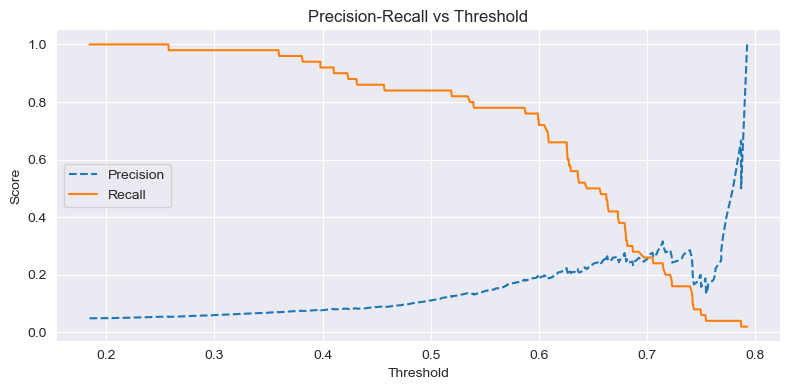

In [40]:
y_probs = best_logreg_pipeline.predict_proba(X_test)[:, 1]

precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs)

pr_df = pd.DataFrame({
    "Threshold": thresholds,
    "Precision": precisions[:-1],
    "Recall": recalls[:-1]
})

plt.figure(figsize=(8, 4))
sns.lineplot(data=pr_df, x="Threshold", y="Precision", label="Precision", linestyle="--")
sns.lineplot(data=pr_df, x="Threshold", y="Recall", label="Recall")

plt.title("Precision-Recall vs Threshold", fontsize=12)
plt.xlabel("Threshold")
plt.ylabel("Score")
sns.despine(top=True, right=True, left=True, bottom=True)

plt.legend()
plt.tight_layout()
plt.show()

In [41]:
optimal_threshold = 0.6

y_pred_adjusted = (y_probs >= optimal_threshold).astype(int)

print(f"Using threshold {optimal_threshold}")
print(classification_report(y_test, y_pred_adjusted))
print(confusion_matrix(y_test, y_pred_adjusted))

trunc_results_list.append({
    'Model': 'LogReg Tuned',
    'F1-Score': f1_class1,
    'Class 1 Precision': precision_class1,
    'Class 1 Recall': recall_class1
})

full_results_list.append({
    'Model': 'LogReg Tuned',
    'F1-Score': f1_class1,
    'Class 1 Precision': precision_class1,
    'Class 1 Recall': recall_class1,
    'False Positives': FP,
    'False Negatives': FN,
    'True Positives': TP
    #'True Negatives': TN
})

Using threshold 0.6
              precision    recall  f1-score   support

           0       0.98      0.84      0.91       972
           1       0.19      0.72      0.30        50

    accuracy                           0.84      1022
   macro avg       0.59      0.78      0.60      1022
weighted avg       0.94      0.84      0.88      1022

[[818 154]
 [ 14  36]]


+ F1 score: 0.30, meaning the model predicts strokes accurately 30% of the time (+26 from baseline, +10 from previous iteration)
+ Confusion Matrix (Class 1, Stroke): 14 false negatives, 36 true positives (+35 from baseline, -5 from previous iteration)
+ Precision for Class 1 (Stroke): 0.19, meaining 19% of the predicted strokes are actual strokes (-81 from baseline, +8 from previous iteration)
+ Recall for Class 1 (Stroke): 0.72, meaning the model predicted 72% of the actual stroke cases (+70 from baseline, -12 from previous iteration)

#### SMOTE

In [42]:
best_logreg_model.fit(X_train_resampled, y_train_resampled)
y_pred = best_logreg_model.predict(X_test_processed)

print("Logistic Regression (SMOTE):")
print(classification_report(y_test, y_pred))
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

precision_class1 = precision_score(y_test, y_pred, pos_label=1)
recall_class1 = recall_score(y_test, y_pred, pos_label=1)
f1_class1 = f1_score(y_test, y_pred, pos_label=1)

TN, FP, FN, TP = conf_matrix.ravel()

trunc_results_list.append({
    'Model': 'LogReg (SMOTE)',
    'F1-Score': f1_class1,
    'Class 1 Precision': precision_class1,
    'Class 1 Recall': recall_class1
})

full_results_list.append({
    'Model': 'LogReg (SMOTE)',
    'F1-Score': f1_class1,
    'Class 1 Precision': precision_class1,
    'Class 1 Recall': recall_class1,
    'False Positives': FP,
    'False Negatives': FN,
    'True Positives': TP
    #'True Negatives': TN
})


Logistic Regression (SMOTE):
              precision    recall  f1-score   support

           0       0.99      0.68      0.81       972
           1       0.12      0.84      0.21        50

    accuracy                           0.69      1022
   macro avg       0.55      0.76      0.51      1022
weighted avg       0.95      0.69      0.78      1022

[[664 308]
 [  8  42]]


+ F1 score: 0.21, meaning the model predicts strokes accurately 21% of the time (+17 from baseline, -9 from previous iteration)
+ Confusion Matrix (Class 1, Stroke): 8 false negatives, 42 true positives (+41 from baseline, +6 from previous iteration)
+ Precision for Class 1 (Stroke): 0.12, meaining 12% of the predicted strokes are actual strokes (-88 from baseline, -5 from previous iteration)
+ Recall for Class 1 (Stroke): 0.84, meaning the model predicted 84% of the actual stroke cases (+82 from baseline, +12 from previous iteration)



Perhaps a different model will be better suited for balancing precision and recall.

### Random Forest

In [43]:
rf_pipeline.fit(X_train, y_train)

y_pred_rf = rf_pipeline.predict(X_test)

print("Random Forest (Basic):")
print(classification_report(y_test, y_pred_rf))
print(confusion_matrix(y_test, y_pred_rf))

precision_class1 = precision_score(y_test, y_pred_rf, pos_label=1)
recall_class1 = recall_score(y_test, y_pred_rf)
f1_class1 = f1_score(y_test, y_pred_rf, pos_label=1)

conf_matrix = confusion_matrix(y_test, y_pred_rf)
TN, FP, FN, TP = conf_matrix.ravel()

trunc_results_list.append({
    'Model': 'RF (Basic)',
    'F1-Score': f1_class1,
    'Class 1 Precision': precision_class1,
    'Class 1 Recall': recall_class1
})

full_results_list.append({
    'Model': 'RF (Basic)',
    'F1-Score': f1_class1,
    'Class 1 Precision': precision_class1,
    'Class 1 Recall': recall_class1,
    'False Positives': FP,
    'False Negatives': FN,
    'True Positives': TP
    #'True Negatives': TN
})

Random Forest (Basic):
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       972
           1       0.40      0.04      0.07        50

    accuracy                           0.95      1022
   macro avg       0.68      0.52      0.52      1022
weighted avg       0.93      0.95      0.93      1022

[[969   3]
 [ 48   2]]


+ F1 score: 0.07, meaning the model predicts strokes accurately 7% of the time (+3 from baseline)
+ Confusion Matrix (Class 1, Stroke): 48 false negatives, 2 true positives (+1 from baseline)
+ Precision for Class 1 (Stroke): 0.40, meaining 40% of the predicted strokes are actual strokes (-60 from baseline)
+ Recall for Class 1 (Stroke): 0.04, meaning the model predicted 4% of the actual stroke cases (+2 from baseline)

#### Hyperparameter Tuning w/ GridSearchCV

In [44]:
#rf_param_grid = {
 #   'classifier__n_estimators': [100, 200, 500],
 #   'classifier__max_depth': [None, 10, 20, 30],
 #   'classifier__min_samples_split': [2, 5, 10],
 #   'classifier__min_samples_leaf': [1, 2, 4],
 #   'classifier__max_features': ['auto', 'sqrt', 'log2']
#}

#grid_search = GridSearchCV(
 #   estimator=rf_pipeline,  
 #   param_grid=rf_param_grid,   
 #   cv=5,                    
 #   scoring='recall',      
 #   verbose=1,             
 #   n_jobs=1                
#)

#grid_search.fit(X_train, y_train)

#best_rf = grid_search.best_estimator_

#y_pred_best_rf = best_rf.predict(X_test)


In [45]:
best_rf_model = RandomForestClassifier(
    max_depth=None,
    max_features='sqrt',
    min_samples_leaf=1,
    min_samples_split=2,
    n_estimators=200,
    random_state=42,
)

best_rf_pipeline = Pipeline(steps=[
    ('preprocessor', rf_preprocessor),
    ('classifier', best_rf_model)
])

best_rf_pipeline.fit(X_train, y_train)
y_pred = best_rf_pipeline.predict(X_test)

print("Random Forest (GSCV):")
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

precision_class1 = precision_score(y_test, y_pred, pos_label=1)
recall_class1 = recall_score(y_test, y_pred, pos_label=1)
f1_class1 = f1_score(y_test, y_pred, pos_label=1)

conf_matrix = confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = conf_matrix.ravel()

trunc_results_list.append({
    'Model': 'RF GSCV',
    'F1-Score': f1_class1,
    'Class 1 Precision': precision_class1,
    'Class 1 Recall': recall_class1
})

full_results_list.append({
    'Model': 'RF GSCV',
    'F1-Score': f1_class1,
    'Class 1 Precision': precision_class1,
    'Class 1 Recall': recall_class1,
    'False Positives': FP,
    'False Negatives': FN,
    'True Positives': TP
    #'True Negatives': TN
})

Random Forest (GSCV):
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       972
           1       0.50      0.04      0.07        50

    accuracy                           0.95      1022
   macro avg       0.73      0.52      0.52      1022
weighted avg       0.93      0.95      0.93      1022

[[970   2]
 [ 48   2]]


Best parameters: {'classifier__max_depth': None, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}

+ F1 score: 0.07, meaning the model predicts strokes accurately 7% of the time (+3 from baseline, +/- 0 from previous iteration)
+ Confusion Matrix (Class 1, Stroke): 48 false negatives, 2 true positives (+1 from baseline, +/- 0 from previous iteration)
+ Precision for Class 1 (Stroke): 0.50, meaining 50% of the predicted strokes are actual strokes (-50 from baseline, +10 from previous iteration)
+ Recall for Class 1 (Stroke): 0.04, meaning the model predicted 4% of the actual stroke cases (+2 from baseline, +/-0 from previous iteration)

#### Precision-Recall Curve

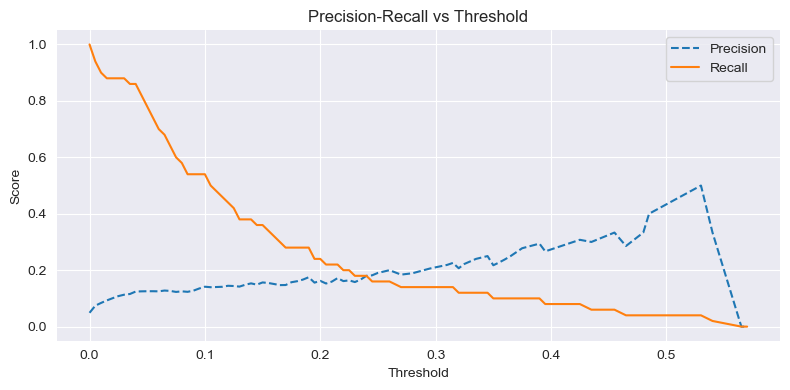

In [46]:
y_probs = best_rf_pipeline.predict_proba(X_test)[:, 1]

precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs)

pr_df = pd.DataFrame({
    "Threshold": thresholds,
    "Precision": precisions[:-1],
    "Recall": recalls[:-1]
})

plt.figure(figsize=(8, 4))
sns.lineplot(data=pr_df, x="Threshold", y="Precision", label="Precision", linestyle="--")
sns.lineplot(data=pr_df, x="Threshold", y="Recall", label="Recall")

plt.title("Precision-Recall vs Threshold", fontsize=12)
plt.xlabel("Threshold")
plt.ylabel("Score")
sns.despine(top=True, right=True, left=True, bottom=True)

plt.legend()
plt.tight_layout()
plt.show()

In [47]:
optimal_threshold = 0.1

y_pred_adjusted = (y_probs >= optimal_threshold).astype(int)

print(f"Using threshold {optimal_threshold}")
print(classification_report(y_test, y_pred_adjusted))
print(confusion_matrix(y_test, y_pred_adjusted))

trunc_results_list.append({
    'Model': 'RF Tuned',
    'F1-Score': f1_class1,
    'Class 1 Precision': precision_class1,
    'Class 1 Recall': recall_class1
})

full_results_list.append({
    'Model': 'RF Tuned',
    'F1-Score': f1_class1,
    'Class 1 Precision': precision_class1,
    'Class 1 Recall': recall_class1,
    'False Positives': FP,
    'False Negatives': FN,
    'True Positives': TP
    #'True Negatives': TN
})

Using threshold 0.1
              precision    recall  f1-score   support

           0       0.97      0.83      0.90       972
           1       0.14      0.54      0.22        50

    accuracy                           0.82      1022
   macro avg       0.56      0.69      0.56      1022
weighted avg       0.93      0.82      0.86      1022

[[808 164]
 [ 23  27]]


#### SMOTE

In [48]:
best_rf_model.fit(X_train_resampled, y_train_resampled)
y_pred = best_rf_model.predict(X_test_processed)

print("Random Forest (SMOTE):")
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

precision_class1 = precision_score(y_test, y_pred, pos_label=1)
recall_class1 = recall_score(y_test, y_pred, pos_label=1)
f1_class1 = f1_score(y_test, y_pred, pos_label=1)

conf_matrix = confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = conf_matrix.ravel()

trunc_results_list.append({
    'Model': 'RF SMOTE',
    'F1-Score': f1_class1,
    'Class 1 Precision': precision_class1,
    'Class 1 Recall': recall_class1
})

full_results_list.append({
    'Model': 'RF SMOTE',
    'F1-Score': f1_class1,
    'Class 1 Precision': precision_class1,
    'Class 1 Recall': recall_class1,
    'False Positives': FP,
    'False Negatives': FN,
    'True Positives': TP
    #'True Negatives': TN
})

Random Forest (SMOTE):
              precision    recall  f1-score   support

           0       0.96      0.95      0.95       972
           1       0.16      0.18      0.17        50

    accuracy                           0.91      1022
   macro avg       0.56      0.56      0.56      1022
weighted avg       0.92      0.91      0.92      1022

[[923  49]
 [ 41   9]]


### XGBoost

In [49]:
xgb_pipeline.fit(X_train, y_train)

y_pred_xgb = xgb_pipeline.predict(X_test)

print("XGBoost (Basic):")
print(classification_report(y_test, y_pred_xgb))
print(confusion_matrix(y_test, y_pred_xgb))

precision_class1 = precision_score(y_test, y_pred_xgb, pos_label=1)
recall_class1 = recall_score(y_test, y_pred_xgb, pos_label=1)
f1_class1 = f1_score(y_test, y_pred_xgb, pos_label=1)

conf_matrix = confusion_matrix(y_test, y_pred_xgb)
TN, FP, FN, TP = conf_matrix.ravel()

trunc_results_list.append({
    'Model': 'XGB (Basic)',
    'F1-Score': f1_class1,
    'Class 1 Precision': precision_class1,
    'Class 1 Recall': recall_class1
})

full_results_list.append({
    'Model': 'XGB (Basic)',
    'F1-Score': f1_class1,
    'Class 1 Precision': precision_class1,
    'Class 1 Recall': recall_class1,
    'False Positives': FP,
    'False Negatives': FN,
    'True Positives': TP
    #'True Negatives': TN
})

XGBoost (Basic):
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       972
           1       0.20      0.06      0.09        50

    accuracy                           0.94      1022
   macro avg       0.58      0.52      0.53      1022
weighted avg       0.92      0.94      0.93      1022

[[960  12]
 [ 47   3]]



+ F1 score: 0.09, meaning the model predicts strokes accurately 9% of the time (+5 from baseline)
+ Confusion Matrix (Class 1, Stroke): 47 false negatives, 3 true positives (+2 from baseline)
+ Precision for Class 1 (Stroke): 0.20, meaining 20% of the predicted strokes are actual strokes (-80 from baseline)
+ Recall for Class 1 (Stroke): 0.06, meaning the model predicted 6% of the actual stroke cases (+4 from baseline)

#### Hyperparameter Tuning w/ GridSearchCV

In [50]:
#param_grid = {
 #   'classifier__learning_rate': [0.01, 0.1, 0.2], 
 #   'classifier__n_estimators': [100, 200, 300],    
 #   'classifier__max_depth': [3, 6, 10],             
 #   'classifier__scale_pos_weight': [1, 2, 5],       
 #   'classifier__subsample': [0.8, 1.0],             
 #   'classifier__colsample_bytree': [0.8, 1.0],     
 #   'classifier__gamma': [0, 0.1, 0.2]              
#}

#grid_search = GridSearchCV(
 #   estimator=xgb_pipeline, 
 #   param_grid=param_grid,  
 #   cv=5,                    
 #   scoring='f1',     
 #   verbose=1,               
 #   n_jobs=1                
#)

#grid_search.fit(X_train, y_train)

#best_xgb = grid_search.best_estimator_

#y_pred_best_xgb = best_xgb.predict(X_test)

In [51]:
best_xgb_model = xgb.XGBClassifier(
    colsample_bytree=0.8,
    reg_lambda=0.1,
    gamma=0.1,
    learning_rate=0.2,
    max_depth=3,
    n_estimators=100,
    subsample=0.8,
    scale_pos_weight=5,
    random_state=42,
    eval_metric='aucpr'
)

best_xgb_pipeline = Pipeline(steps=[
    ('preprocessor', xgb_preprocessor),
    ('classifier', best_xgb_model)
])

best_xgb_pipeline.fit(X_train, y_train)
y_pred = best_xgb_pipeline.predict(X_test)

print("XGBoost (GSCV):")
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

precision_class1 = precision_score(y_test, y_pred, pos_label=1)
recall_class1 = recall_score(y_test, y_pred, pos_label=1)
f1_class1 = f1_score(y_test, y_pred, pos_label=1)

conf_matrix = confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = conf_matrix.ravel()

trunc_results_list.append({
    'Model': 'XGB GSCV',
    'F1-Score': f1_class1,
    'Class 1 Precision': precision_class1,
    'Class 1 Recall': recall_class1
})

full_results_list.append({
    'Model': 'XGB GSCV',
    'F1-Score': f1_class1,
    'Class 1 Precision': precision_class1,
    'Class 1 Recall': recall_class1,
    'False Positives': FP,
    'False Negatives': FN,
    'True Positives': TP
    #'True Negatives': TN
})

XGBoost (GSCV):
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       972
           1       0.21      0.22      0.22        50

    accuracy                           0.92      1022
   macro avg       0.59      0.59      0.59      1022
weighted avg       0.92      0.92      0.92      1022

[[931  41]
 [ 39  11]]


Best parameters: {'classifier__colsample_bytree': 0.8, 'classifier__gamma': 0.1, 'classifier__learning_rate': 0.2, 'classifier__max_depth': 3, 'classifier__n_estimators': 100, 'classifier__scale_pos_weight': 5, 'classifier__subsample': 0.8}

+ F1 score: 0.22, meaning the model predicts strokes accurately 22% of the time (+18 from baseline, +14 from previous iteration)
+ Confusion Matrix (Class 1, Stroke): 39 false negatives, 11 true positives (+10 from baseline, +8 from previous iteration)
+ Precision for Class 1 (Stroke): 0.25, meaining 25% of the predicted strokes are actual strokes (-75 from baseline, +5 from previous iteration)
+ Recall for Class 1 (Stroke): 0.22, meaning the model predicted 22% of the actual stroke cases (+20 from baseline, +16 from previous iteration)

#### SMOTE

In [52]:
best_xgb_model.fit(X_train_resampled, y_train_resampled)
y_pred = best_xgb_model.predict(X_test_processed)

print("XGBoost (GCSV + SMOTE):")
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

precision_class1 = precision_score(y_test, y_pred, pos_label=1)
recall_class1 = recall_score(y_test, y_pred, pos_label=1)
f1_class1 = f1_score(y_test, y_pred, pos_label=1)

conf_matrix = confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = conf_matrix.ravel()

trunc_results_list.append({
    'Model': 'XGB SMOTE',
    'F1-Score': f1_class1,
    'Class 1 Precision': precision_class1,
    'Class 1 Recall': recall_class1
})

full_results_list.append({
    'Model': 'XGB SMOTE',
    'F1-Score': f1_class1,
    'Class 1 Precision': precision_class1,
    'Class 1 Recall': recall_class1,
    'False Positives': FP,
    'False Negatives': FN,
    'True Positives': TP
    #'True Negatives': TN
})

XGBoost (GCSV + SMOTE):
              precision    recall  f1-score   support

           0       0.97      0.74      0.84       972
           1       0.11      0.62      0.18        50

    accuracy                           0.73      1022
   macro avg       0.54      0.68      0.51      1022
weighted avg       0.93      0.73      0.81      1022

[[716 256]
 [ 19  31]]


+ F1 score: 0.18, meaning the model predicts strokes accurately 18% of the time (+14 from baseline, -4 from previous iteration)
+ Confusion Matrix (Class 1, Stroke): 19 false negatives, 31 true positives (+30 from baseline, +20 from previous iteration)
+ Precision for Class 1 (Stroke): 0.11, meaining 11% of the predicted strokes are actual strokes (-89 from baseline, -14 from previous iteration)
+ Recall for Class 1 (Stroke): 0.62, meaning the model predicted 62% of the actual stroke cases (+60 from baseline, +40 from previous iteration)

### Voting Classifier

In [53]:
voting_clf = VotingClassifier(
    estimators=[
        ('logreg', best_logreg_pipeline),
        ('rf', best_rf_pipeline),
        ('xgb', best_xgb_pipeline)
    ],
    voting='soft'
)

voting_clf.fit(X_train, y_train)

y_probs_ensemble = voting_clf.predict_proba(X_test)[:, 1]
y_pred_ensemble = voting_clf.predict(X_test)

print("Voting Classifier:")
print(classification_report(y_test, y_pred_ensemble))
conf_matrix = confusion_matrix(y_test, y_pred_ensemble)
print(conf_matrix)

precision_class1 = precision_score(y_test, y_pred_ensemble, pos_label=1)
recall_class1 = recall_score(y_test, y_pred_ensemble, pos_label=1)
f1_class1 = f1_score(y_test, y_pred_ensemble, pos_label=1)

TN, FP, FN, TP = conf_matrix.ravel()

trunc_results_list.append({
    'Model': 'VC',
    'F1-Score': f1_class1,
    'Class 1 Precision': precision_class1,
    'Class 1 Recall': recall_class1
})

full_results_list.append({
    'Model': 'VC',
    'F1-Score': f1_class1,
    'Class 1 Precision': precision_class1,
    'Class 1 Recall': recall_class1,
    'False Positives': FP,
    'False Negatives': FN,
    'True Positives': TP
    #'True Negatives': TN
})

Voting Classifier:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       972
           1       0.27      0.16      0.20        50

    accuracy                           0.94      1022
   macro avg       0.61      0.57      0.58      1022
weighted avg       0.92      0.94      0.93      1022

[[950  22]
 [ 42   8]]



+ F1 score: 0.20, meaning the model predicts strokes accurately 20% of the time (+16 from baseline)
+ Confusion Matrix (Class 1, Stroke): 42 false negatives, 8 true positives (+7 from baseline)
+ Precision for Class 1 (Stroke): 0.27, meaining 27% of the predicted strokes are actual strokes (-73 from baseline)
+ Recall for Class 1 (Stroke): 0.16, meaning the model predicted 6% of the actual stroke cases (+14 from baseline)

#### SMOTE

In [54]:
voting_clf_smote = VotingClassifier(
    estimators=[
        ('logreg', best_logreg_model),
        ('rf', best_rf_model),
        ('xgb', best_xgb_model)
    ],
    voting='soft'
)

voting_clf_smote.fit(X_train_resampled, y_train_resampled)

y_probs_ensemble = voting_clf_smote.predict_proba(X_test_processed)[:, 1]
y_pred_ensemble = voting_clf_smote.predict(X_test_processed)


print("Voting Classifier (SMOTE):")
print(classification_report(y_test, y_pred_ensemble))
conf_matrix = confusion_matrix(y_test, y_pred_ensemble)
print(conf_matrix)

precision_class1 = precision_score(y_test, y_pred_ensemble, pos_label=1)
recall_class1 = recall_score(y_test, y_pred_ensemble, pos_label=1)
f1_class1 = f1_score(y_test, y_pred_ensemble, pos_label=1)

TN, FP, FN, TP = conf_matrix.ravel()

trunc_results_list.append({
    'Model': 'VC SMOTE',
    'F1-Score': f1_class1,
    'Class 1 Precision': precision_class1,
    'Class 1 Recall': recall_class1
})

full_results_list.append({
    'Model': 'VC SMOTE',
    'F1-Score': f1_class1,
    'Class 1 Precision': precision_class1,
    'Class 1 Recall': recall_class1,
    'False Positives': FP,
    'False Negatives': FN,
    'True Positives': TP
    #'True Negatives': TN
})

Voting Classifier (SMOTE):
              precision    recall  f1-score   support

           0       0.98      0.86      0.91       972
           1       0.17      0.58      0.26        50

    accuracy                           0.84      1022
   macro avg       0.57      0.72      0.59      1022
weighted avg       0.94      0.84      0.88      1022

[[832 140]
 [ 21  29]]



+ F1 score: 0.26, meaning the model predicts strokes accurately 26% of the time (+16 from baseline, +6 from previous iteration)
+ Confusion Matrix (Class 1, Stroke): 21 false negatives, 29 true positives (+28 from baseline, +21 from previous iteration)
+ Precision for Class 1 (Stroke): 0.17, meaining 17% of the predicted strokes are actual strokes (-83 from baseline, -10 from previous iteration)
+ Recall for Class 1 (Stroke): 0.58, meaning the model predicted 58% of the actual stroke cases (+38 from baseline, +42 from previous iteration)

## Model Performance Comparison

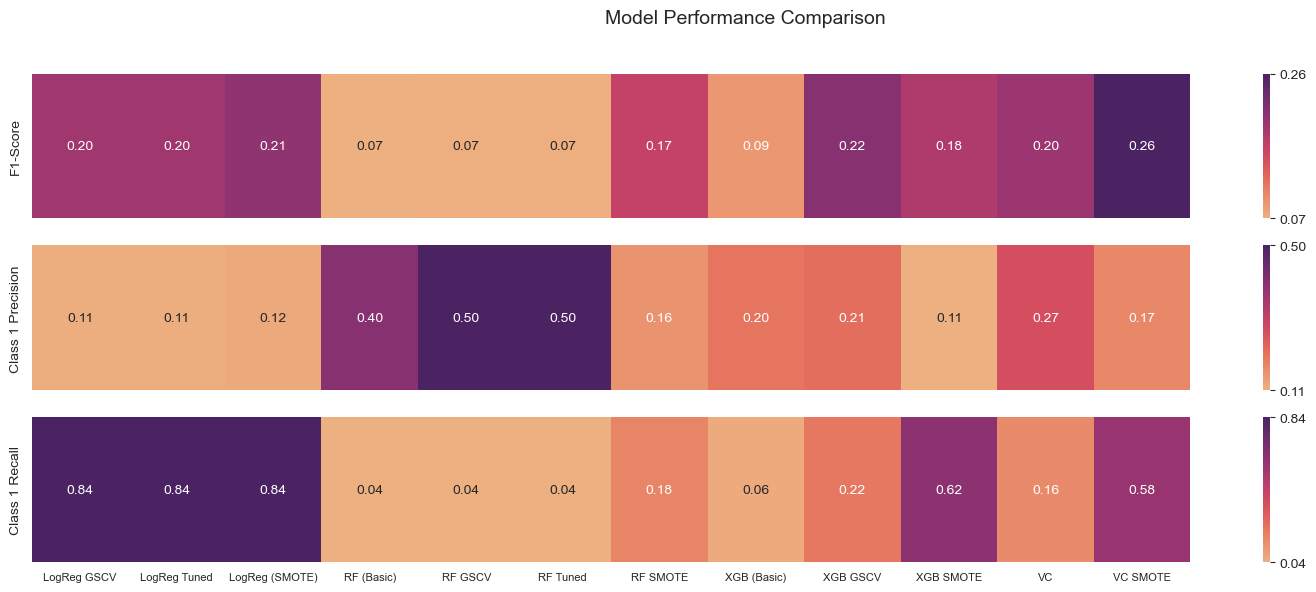

In [55]:
results_df = pd.DataFrame(trunc_results_list)
results_df.set_index('Model', inplace=True)
results_df = results_df.T

num_metrics = results_df.shape[0]
fig, axes = plt.subplots(num_metrics, 1, figsize=(15, 2 * num_metrics), sharex=True)

for i, metric in enumerate(results_df.index):
    ax = axes[i] if num_metrics > 1 else axes
    
    vmin, vmax = results_df.loc[metric].min(), results_df.loc[metric].max()
    
    heatmap = sns.heatmap(results_df.loc[[metric]], annot=True, cmap='flare', cbar=True, fmt='.2f', 
                          linewidths=0, linecolor='gray', ax=ax, vmin=vmin, vmax=vmax)
    
    cbar = heatmap.collections[0].colorbar
    cbar.set_ticks([vmin, vmax])
    cbar.set_ticklabels([f"{vmin:.2f}", f"{vmax:.2f}"])
    
    ax.set_ylabel('')
    ax.set_xlabel('') 
    ax.set_xticklabels(results_df.columns, rotation=0, ha='center', fontsize=8)

plt.suptitle('Model Performance Comparison', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96]) 
plt.show()

+ Best F1-scores
    1. 0.26: Voting Classifier (SMOTE)
    2. 0.22: XGBoost GridSearchCV
    3. 0.21: Logistic Regression (SMOTE)
+ Best Class 1 Recall
    1. 0.84: Logistic Regression GridSearchCV, Logistic Regression Tuned, Logistic Regression (SMOTE)
    2. 0.62: XGBoost (SMOTE)
    3. 0.58: Voting Classifier (SMOTE)
+ Best Class 1 Precision:
    1. 0.50: Random Forest GridSearchCV, Random Forest Tuned
    2. 0.40: Random Forest Basic
    3. 0.27: Voting CLassifier Basic

# Conclusions and Recommendations

In attempting to identify those likely to have a stroke, false negatives (missing people who are in fact likely to have a stroke) are probably of higher concern than false positives (capturing people who are not in fact likely to have a stroke). Therefore, the best model for this application is likely one of the voting classifier models. Voting Classifier (SMOTE) had the highest F1-score as 0.26, and F1-score was the primary metric. Balancing precision and recall was a challenge with this unbalanced data. Domain knowledge could help in deciding to what extent precision should be sacrificed for recall. 

This analysis could be improved with:

+ Collecting more data from those who have had strokes to rectify the class imbalance
+ Further feature engineering
+ Further model experimentation